In [1]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline

Using TensorFlow backend.
C:\ProgramData\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\envs\py36\lib\site-packag

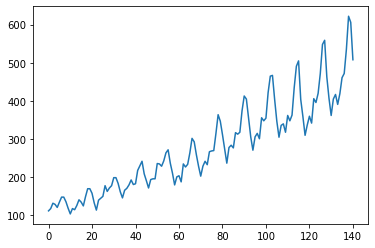

In [2]:
dataframe = read_csv('AirPassengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
# 将整型变为float
dataset = dataset.astype('float32')

plt.plot(dataset)
plt.show()

In [3]:
dataset.shape

(141, 1)

In [4]:
dataset

array([[112.],
       [118.],
       [132.],
       [129.],
       [121.],
       [135.],
       [148.],
       [148.],
       [136.],
       [119.],
       [104.],
       [118.],
       [115.],
       [126.],
       [141.],
       [135.],
       [125.],
       [149.],
       [170.],
       [170.],
       [158.],
       [133.],
       [114.],
       [140.],
       [145.],
       [150.],
       [178.],
       [163.],
       [172.],
       [178.],
       [199.],
       [199.],
       [184.],
       [162.],
       [146.],
       [166.],
       [171.],
       [180.],
       [193.],
       [181.],
       [183.],
       [218.],
       [230.],
       [242.],
       [209.],
       [191.],
       [172.],
       [194.],
       [196.],
       [196.],
       [236.],
       [235.],
       [229.],
       [243.],
       [264.],
       [272.],
       [237.],
       [211.],
       [180.],
       [201.],
       [204.],
       [188.],
       [235.],
       [227.],
       [234.],
       [264.],
       [30

In [5]:
# X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).

# convert an array of values into a dataset matrix 
# look_back表示每个输入数据与前多少个陆续输入的数据有联系
# look_back 就是预测下一步所需要的 time steps：
# timesteps 就是 LSTM 认为每个输入数据与前多少个陆续输入的数据有联系。
# 例如具有这样用段序列数据 “…ABCDBCEDF…”，当 timesteps 为 3 时，在模型预测中如果输入数据为“D”，
# 那么之前接收的数据如果为“B”和“C”则此时的预测输出为 B 的概率更大，之前接收的数据如果为“C”和“E”，
# 则此时的预测输出为 F 的概率更大。

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):  # 94-2=92 0-91
        a = dataset[i:(i+look_back), 0]  # 0:1  1:2 ... 91:92
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])  # 1  2 ... 92
    return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)

In [6]:
# normalize the dataset 归一化
# 当激活函数为 sigmoid 或者 tanh 时，要把数据正则话，此时 LSTM 比较敏感
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


# split into train and test sets
# 训练集 67%
# 测试集 33%
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [7]:
dataset.shape

(141, 1)

In [8]:
dataset

array([[0.01544401],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853],
       [0.05984557],
       [0.08494207],
       [0.08494207],
       [0.06177607],
       [0.02895753],
       [0.        ],
       [0.02702703],
       [0.02123553],
       [0.04247104],
       [0.07142857],
       [0.05984557],
       [0.04054055],
       [0.08687258],
       [0.12741312],
       [0.12741312],
       [0.10424709],
       [0.05598456],
       [0.01930502],
       [0.06949806],
       [0.07915059],
       [0.08880308],
       [0.14285713],
       [0.11389962],
       [0.13127413],
       [0.14285713],
       [0.18339768],
       [0.18339768],
       [0.15444016],
       [0.11196911],
       [0.08108109],
       [0.1196911 ],
       [0.12934363],
       [0.14671814],
       [0.17181468],
       [0.14864865],
       [0.15250966],
       [0.22007722],
       [0.24324325],
       [0.26640925],
       [0.2027027 ],
       [0.16795367],
       [0.13127413],
       [0.173

In [9]:
# use this function to prepare the train and test datasets for modeling
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [10]:
train.shape

(94, 1)

In [11]:
train

array([[0.01544401],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853],
       [0.05984557],
       [0.08494207],
       [0.08494207],
       [0.06177607],
       [0.02895753],
       [0.        ],
       [0.02702703],
       [0.02123553],
       [0.04247104],
       [0.07142857],
       [0.05984557],
       [0.04054055],
       [0.08687258],
       [0.12741312],
       [0.12741312],
       [0.10424709],
       [0.05598456],
       [0.01930502],
       [0.06949806],
       [0.07915059],
       [0.08880308],
       [0.14285713],
       [0.11389962],
       [0.13127413],
       [0.14285713],
       [0.18339768],
       [0.18339768],
       [0.15444016],
       [0.11196911],
       [0.08108109],
       [0.1196911 ],
       [0.12934363],
       [0.14671814],
       [0.17181468],
       [0.14864865],
       [0.15250966],
       [0.22007722],
       [0.24324325],
       [0.26640925],
       [0.2027027 ],
       [0.16795367],
       [0.13127413],
       [0.173

In [12]:
trainX.shape

(92, 1)

In [13]:
trainX

array([[0.01544401],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853],
       [0.05984557],
       [0.08494207],
       [0.08494207],
       [0.06177607],
       [0.02895753],
       [0.        ],
       [0.02702703],
       [0.02123553],
       [0.04247104],
       [0.07142857],
       [0.05984557],
       [0.04054055],
       [0.08687258],
       [0.12741312],
       [0.12741312],
       [0.10424709],
       [0.05598456],
       [0.01930502],
       [0.06949806],
       [0.07915059],
       [0.08880308],
       [0.14285713],
       [0.11389962],
       [0.13127413],
       [0.14285713],
       [0.18339768],
       [0.18339768],
       [0.15444016],
       [0.11196911],
       [0.08108109],
       [0.1196911 ],
       [0.12934363],
       [0.14671814],
       [0.17181468],
       [0.14864865],
       [0.15250966],
       [0.22007722],
       [0.24324325],
       [0.26640925],
       [0.2027027 ],
       [0.16795367],
       [0.13127413],
       [0.173

In [14]:
trainY.shape

(92,)

In [15]:
trainY

array([0.02702703, 0.05405405, 0.04826255, 0.03281853, 0.05984557,
       0.08494207, 0.08494207, 0.06177607, 0.02895753, 0.        ,
       0.02702703, 0.02123553, 0.04247104, 0.07142857, 0.05984557,
       0.04054055, 0.08687258, 0.12741312, 0.12741312, 0.10424709,
       0.05598456, 0.01930502, 0.06949806, 0.07915059, 0.08880308,
       0.14285713, 0.11389962, 0.13127413, 0.14285713, 0.18339768,
       0.18339768, 0.15444016, 0.11196911, 0.08108109, 0.1196911 ,
       0.12934363, 0.14671814, 0.17181468, 0.14864865, 0.15250966,
       0.22007722, 0.24324325, 0.26640925, 0.2027027 , 0.16795367,
       0.13127413, 0.17374519, 0.17760617, 0.17760617, 0.25482625,
       0.25289574, 0.24131274, 0.26833975, 0.3088803 , 0.32432434,
       0.25675675, 0.20656371, 0.14671814, 0.18725869, 0.19305018,
       0.16216215, 0.25289574, 0.23745173, 0.25096524, 0.3088803 ,
       0.38223937, 0.36486486, 0.2992278 , 0.24131274, 0.1911197 ,
       0.24131274, 0.26640925, 0.24903473, 0.31467178, 0.31853

In [16]:
testX.shape

(45, 1)

In [17]:
testX

array([[0.3223938 ],
       [0.3899614 ],
       [0.4073359 ],
       [0.3803089 ],
       [0.48648646],
       [0.47104248],
       [0.484556  ],
       [0.6138996 ],
       [0.6969112 ],
       [0.70077217],
       [0.57915056],
       [0.46911195],
       [0.38803086],
       [0.44787642],
       [0.45559844],
       [0.4131274 ],
       [0.4980695 ],
       [0.47104248],
       [0.49999997],
       [0.6389961 ],
       [0.7471043 ],
       [0.7741313 ],
       [0.57915056],
       [0.492278  ],
       [0.3976834 ],
       [0.44980696],
       [0.49420848],
       [0.45945945],
       [0.5830116 ],
       [0.5637065 ],
       [0.61003864],
       [0.71042466],
       [0.8571429 ],
       [0.8783784 ],
       [0.69305015],
       [0.5849421 ],
       [0.4980695 ],
       [0.58108103],
       [0.6042471 ],
       [0.554054  ],
       [0.60810804],
       [0.6891892 ],
       [0.71042466],
       [0.8320464 ],
       [1.        ]], dtype=float32)

In [18]:
testY.shape

(45,)

In [19]:
testY

array([0.3899614 , 0.4073359 , 0.3803089 , 0.48648646, 0.47104248,
       0.484556  , 0.6138996 , 0.6969112 , 0.70077217, 0.57915056,
       0.46911195, 0.38803086, 0.44787642, 0.45559844, 0.4131274 ,
       0.4980695 , 0.47104248, 0.49999997, 0.6389961 , 0.7471043 ,
       0.7741313 , 0.57915056, 0.492278  , 0.3976834 , 0.44980696,
       0.49420848, 0.45945945, 0.5830116 , 0.5637065 , 0.61003864,
       0.71042466, 0.8571429 , 0.8783784 , 0.69305015, 0.5849421 ,
       0.4980695 , 0.58108103, 0.6042471 , 0.554054  , 0.60810804,
       0.6891892 , 0.71042466, 0.8320464 , 1.        , 0.96911204],
      dtype=float32)

In [20]:
# reshape input to be [samples, time steps, features]
# 投入到 LSTM 的 X 需要有这样的结构： [samples, time steps, features]，所以做一下变换
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [21]:
trainX.shape

(92, 1, 1)

In [22]:
trainX

array([[[0.01544401]],

       [[0.02702703]],

       [[0.05405405]],

       [[0.04826255]],

       [[0.03281853]],

       [[0.05984557]],

       [[0.08494207]],

       [[0.08494207]],

       [[0.06177607]],

       [[0.02895753]],

       [[0.        ]],

       [[0.02702703]],

       [[0.02123553]],

       [[0.04247104]],

       [[0.07142857]],

       [[0.05984557]],

       [[0.04054055]],

       [[0.08687258]],

       [[0.12741312]],

       [[0.12741312]],

       [[0.10424709]],

       [[0.05598456]],

       [[0.01930502]],

       [[0.06949806]],

       [[0.07915059]],

       [[0.08880308]],

       [[0.14285713]],

       [[0.11389962]],

       [[0.13127413]],

       [[0.14285713]],

       [[0.18339768]],

       [[0.18339768]],

       [[0.15444016]],

       [[0.11196911]],

       [[0.08108109]],

       [[0.1196911 ]],

       [[0.12934363]],

       [[0.14671814]],

       [[0.17181468]],

       [[0.14864865]],

       [[0.15250966]],

       [[0.22007

In [23]:
testX.shape

(45, 1, 1)

In [24]:
testX

array([[[0.3223938 ]],

       [[0.3899614 ]],

       [[0.4073359 ]],

       [[0.3803089 ]],

       [[0.48648646]],

       [[0.47104248]],

       [[0.484556  ]],

       [[0.6138996 ]],

       [[0.6969112 ]],

       [[0.70077217]],

       [[0.57915056]],

       [[0.46911195]],

       [[0.38803086]],

       [[0.44787642]],

       [[0.45559844]],

       [[0.4131274 ]],

       [[0.4980695 ]],

       [[0.47104248]],

       [[0.49999997]],

       [[0.6389961 ]],

       [[0.7471043 ]],

       [[0.7741313 ]],

       [[0.57915056]],

       [[0.492278  ]],

       [[0.3976834 ]],

       [[0.44980696]],

       [[0.49420848]],

       [[0.45945945]],

       [[0.5830116 ]],

       [[0.5637065 ]],

       [[0.61003864]],

       [[0.71042466]],

       [[0.8571429 ]],

       [[0.8783784 ]],

       [[0.69305015]],

       [[0.5849421 ]],

       [[0.4980695 ]],

       [[0.58108103]],

       [[0.6042471 ]],

       [[0.554054  ]],

       [[0.60810804]],

       [[0.68918

In [25]:
# create and fit the LSTM network
# 输入层有 1 个input，隐藏层有 4 个神经元，输出层就是预测一个值，激活函数用 sigmoid，迭代 100 次，batch size 为 1
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)




Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Epoch 1/100
 - 0s - loss: 0.0404
Epoch 2/100
 - 0s - loss: 0.0200
Epoch 3/100
 - 0s - loss: 0.0146
Epoch 4/100
 - 0s - loss: 0.0135
Epoch 5/100
 - 0s - loss: 0.0124
Epoch 6/100
 - 0s - loss: 0.0116
Epoch 7/100
 - 0s - loss: 0.0105
Epoch 8/100
 - 0s - loss: 0.0096
Epoch 9/100
 - 0s - loss: 0.0086
Epoch 10/100
 - 0s - loss: 0.0075
Epoch 11/100
 - 0s - loss: 0.0066
Epoch 12/100
 - 0s - loss: 0.0056
Epoch 13/100
 - 0s - loss: 0.0049
Epoch 14/100
 - 0s - loss: 0.0041
Epoch 15/100
 - 0s - loss: 0.0035
Epoch 16/100
 - 0s - loss: 0.0030
Epoch 17/100
 - 0s - loss: 0.0027
Epoch 18/100
 - 0s - loss: 0.0024
Epoch 19/100
 - 0s - loss: 0.0022
Epoch 20/100
 - 0s - loss: 0.0021
Epoch 21/100
 - 0s - loss: 0.0020
Epoc

In [26]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [27]:
trainPredict.shape

(92, 1)

In [28]:
trainPredict

array([[0.03662728],
       [0.04664887],
       [0.07043651],
       [0.06529309],
       [0.05169941],
       [0.07560426],
       [0.098267  ],
       [0.098267  ],
       [0.07733215],
       [0.04832948],
       [0.02343494],
       [0.04664887],
       [0.04162469],
       [0.06017437],
       [0.08601072],
       [0.07560426],
       [0.05847372],
       [0.1000277 ],
       [0.13752781],
       [0.13752781],
       [0.11597975],
       [0.07215643],
       [0.03995589],
       [0.08426985],
       [0.09299946],
       [0.1017908 ],
       [0.15205526],
       [0.12492096],
       [0.14114805],
       [0.15205526],
       [0.19072486],
       [0.19072486],
       [0.16302885],
       [0.12312838],
       [0.09475286],
       [0.13031144],
       [0.13933694],
       [0.15570597],
       [0.17960426],
       [0.15753403],
       [0.1611955 ],
       [0.22625701],
       [0.2488998 ],
       [0.2716569 ],
       [0.20937085],
       [0.17590953],
       [0.14114805],
       [0.181

In [29]:
testPredict.shape

(45, 1)

In [30]:
testPredict

array([[0.32691756],
       [0.39357886],
       [0.4106311 ],
       [0.384084  ],
       [0.4874145 ],
       [0.47257277],
       [0.4855636 ],
       [0.606345  ],
       [0.679809  ],
       [0.68314093],
       [0.57459915],
       [0.4707121 ],
       [0.39168102],
       [0.45017186],
       [0.45765617],
       [0.4163026 ],
       [0.49849334],
       [0.47257277],
       [0.50033516],
       [0.6289164 ],
       [0.72252226],
       [0.744977  ],
       [0.57459915],
       [0.49295974],
       [0.40116426],
       [0.45204455],
       [0.4948056 ],
       [0.46139202],
       [0.57815397],
       [0.5603137 ],
       [0.60284555],
       [0.69143736],
       [0.8115666 ],
       [0.82803226],
       [0.6764691 ],
       [0.57992876],
       [0.49849334],
       [0.5763774 ],
       [0.59758306],
       [0.5513324 ],
       [0.60109305],
       [0.67312175],
       [0.69143736],
       [0.7918107 ],
       [0.918069  ]], dtype=float32)

In [31]:
# invert predictions 
# 计算误差之前要先把预测数据转换成同一单位
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [32]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.34 RMSE
Test Score: 45.66 RMSE


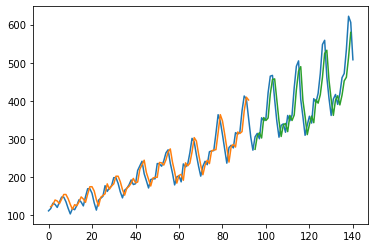

In [33]:
# 蓝色为原数据，红色为训练集的预测值，绿色为测试集的预测值，
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()